In [1]:
'''
#******IMPORTANT*****
#If you have missing libraries, uncomment these
!pip install numpy
!pip install mediapipe
!pip install pycaw
!pip install opencv-python
!pip install matplotlib
'''

'\n#If you have missing libraries, uncomment these\n!pip install numpy\n!pip install mediapipe\n!pip install pycaw\n!pip install opencv-python\n!pip install matplotlib\n'

In [2]:
#Ertuğrul Kuşva
#Libraries
import cv2
import mediapipe as mp
import time
import numpy as np
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
from comtypes import CLSCTX_ALL
from ctypes import cast, POINTER
from matplotlib import pyplot as plt



Mediapipe pose and hand landmarks model map
![title](image1.png)
![title](image2.png)

In [3]:
#Mediapipe library initialization
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose



In [4]:
#pycaw library initialization and video recording
pTime = 0
font = cv2.FONT_HERSHEY_SIMPLEX
gCam, yCam = 640,480
# For webcam input:
cap = cv2.VideoCapture(0)
cap.set(3, gCam)
cap.set(4, yCam)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640,480))
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(
IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))

minVol=0
maxVol=0
#volume params
vol = 0
volBar = 400
volPer = 0
start = time.time()

show_osd=False
counter=0
volume_bar_coord=0,0
index_finger2=0,0
distance=100
volume_bar=200
percentage=0

In [5]:
def volumBar(img):
    global volume_bar
    global percentage
    #volRange = volume.GetVolumeRange()
    volRange = volume.GetMasterVolumeLevelScalar()
    
    #minVol = volRange[0]
    #maxVol = volRange[1]   
    length=0
    #### overlay space     
    oalpha = 0.7
    overlay = img.copy()
    output = img.copy()
    if volume_bar>410:
        volume_bar=410
    elif volume_bar<143:
        volume_bar=143     
        
    if percentage == 0:
        volume_control= -0.0
    elif percentage <0 :
         volume_control= percentage *-1.0
        
    vol = np.interp(percentage, [0,100], [100,0])
    vol= round(vol, 1)
    
    volume.SetMasterVolumeLevelScalar(vol/100, None)  
    cv2.rectangle(overlay,(43, 143), (92, 410), (255,0,0), -1)
    cv2.rectangle(overlay,(43, 143), (92, volume_bar), (0,0,0), -1)    
    cv2.addWeighted(overlay, oalpha, output, 1- oalpha, 0, img)
    return img


In [6]:
cap = cv2.VideoCapture(0)
#Minimum detection threshold values, These values are recommended on the Mediapipe website.
#You can try decreasing or increasing  the values for more precise detection
with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands, mp_pose.Pose(min_detection_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    
    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use break instead of continue.
        continue

    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image = cv2.cvtColor(cv2.flip(image,1), cv2.COLOR_BGR2RGB)
    #cv2.flip(image, 1)
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = hands.process(image)
    results2= pose.process(image)
   
    
    # Draw the hand annotations on the image
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    h,w,c = image.shape
    #Keypoints extractions
    if results2.pose_landmarks:
        landmarks = results2.pose_landmarks.landmark
        l_shoulder=landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y
        r_shoulder=landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y
        r_mouth=landmarks[mp_pose.PoseLandmark.MOUTH_RIGHT.value].x,landmarks[mp_pose.PoseLandmark.MOUTH_RIGHT.value].y

        volumBarX=int((((92-43)/2)+43))
        volumBarY=int((((410-143)/2)+143))
        volume_bar_coord =volumBarX,volumBarY
        volume_bar_coord= np.array(volume_bar_coord)    
        l_shoulder= np.array(l_shoulder)
        r_shoulder= np.array(r_shoulder)
        r_mouth=np.array(r_mouth)
        dist = np.sqrt(np.sum((l_shoulder-r_shoulder)**2))
                    
        #for pose_landmarks in results2.pose_world_landmarks:
        mp_drawing.draw_landmarks(image,results2.pose_landmarks,mp_pose.POSE_CONNECTIONS)
    if results.multi_hand_landmarks:
      for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        lbl = results.multi_handedness[idx].classification[0].label
        landmarksEL = results.multi_hand_landmarks[idx].landmark 
    
        #print(cx,cy, h,w,c)
        #lmList.append([id,cx,cy])
        if lbl=="Left":
            index_finger=results.multi_hand_landmarks[idx].landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
            index_finger1=index_finger.x,index_finger.y
            index_finger2=int(index_finger.x*w),int(index_finger.y*h)
            index_finger1= np.array(index_finger1)
            index_finger2= np.array(index_finger2)
            dist1 = np.sqrt(np.sum((r_mouth-index_finger1)**2))
            distance=int(dist1*w)
            
            if distance < 10:
                show_osd=True                
                start = time.time()
            cx,cy = int(index_finger.x*w), int(index_finger.y*h)            
            cv2.circle(image,(cx,cy), 10, (255,0,255),cv2.cv2.FILLED)                

                
        mp_drawing.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
            drawing_styles.get_default_hand_landmark_style(),
            drawing_styles.get_default_hand_connection_style())    
      

    end = time.time()
    counter=int(end-start) 
    
    #cv2.rectangle(overlay,(43, 143), (92, 410), (255,0,0), -1)
    #cv2.rectangle(overlay,(43, 143), (92, 200), (0,0,0), -1) 
       

    if counter<5 and show_osd ==True:
        image=volumBar(image)
    else :
        show_osd=False
    
    if show_osd ==True and (index_finger2[0]>43 and index_finger2[0]<143):
        start = time.time()
        cx,cy = int(index_finger.x*w), int(index_finger.y*h)            
        cv2.circle(image,(cx,cy), 10, (255,0,255),cv2.cv2.FILLED)
        percentage = int(((index_finger2[1] - 140) / (415 - 140))*100)
        #percentage = int(((index_finger2[1]) * (415 - 140))/100)
        volume_bar =index_finger2[1]
        #volume_bar = int(((index_finger2[1]) * (415 - 140))/100)
        
        
        if percentage>100:
            percentage=100
        elif percentage<0:
            percentage=0

        
    cv2.putText(image, f'fps:{int(fps)} pc_volume:{100-percentage} osd:{counter} volume_bar:{volume_bar}', (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 1)
    
    cv2.imshow('MediaPipe Volume-Ertugrul Kusva', image)
    out.write(image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
cap.release()
out.release()
cv2.destroyAllWindows()

    
    
    
   

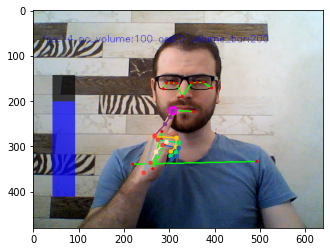

In [7]:
#Last frame showing
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)) 

In [ ]:
#If the program does not exit after pressing q, you can turn off with this.
out.release()
cap.release()
cv2.destroyAllWindows()